# Self-design Neural Network for recommendation system

## Data preprocessing

In [1]:
import numpy as np
import pandas as pd

rating_df = pd.read_csv('./animelist.csv', 
                        low_memory=False, 
                        usecols=["user_id", "anime_id", "rating","watched_episodes","watching_status"]
                        #, nrows=90000000
                        )
rating_df.head(4)

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1


In [2]:
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()
len(rating_df)

71418114

In [3]:
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(rating_df['rating'])
print('Avg', AvgRating)

Avg 0.40477935891013467


In [4]:
duplicates = rating_df.duplicated()

if duplicates.sum() > 0:
    print('> {} duplicates'.format(duplicates.sum()))
    rating_df = rating_df[~duplicates]

print('> {} duplicates'.format(rating_df.duplicated().sum()))

> 1 duplicates
> 0 duplicates


In [1]:
# Connect to TPU(optional)
import tensorflow as tf

#TPU_INIT = True

#if TPU_INIT:
    #tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect('mnist-tutorial')
    #tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
#else:
    #!nvidia-smi
    
print(tf.__version__)

2.7.0


# Encode input layers

In [5]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

print("Num of users: {}, Num of animes: {}".format(n_users, n_animes))
print("Min rating: {}, Max rating: {}".format(min(rating_df['rating']), max(rating_df['rating'])))

Num of users: 91641, Num of animes: 17560
Min rating: 0.0, Max rating: 1.0


In [6]:
we_ids = rating_df["watched_episodes"].unique().tolist()
we2we_encoded = {x: i for i, x in enumerate(we_ids)}
n_we = len(we2we_encoded)
print(n_we)

1319


In [7]:
ws_ids = rating_df["watching_status"].unique().tolist()
ws2ws_encoded = {x: i for i, x in enumerate(ws_ids)}
n_ws = len(ws2ws_encoded)
print(n_ws)

9


In [8]:
rating_df.head(4)

,user_id,anime_id,rating,watching_status,watched_episodes,user,anime
213,2,24833,0.0,1,0,0,0
214,2,235,1.0,1,100,0,1
215,2,36721,0.0,1,1,0,2
216,2,40956,0.0,1,0,0,3


In [9]:
rating_df = rating_df.sample(frac=1, random_state=73)

X = rating_df[['user', 'anime','watching_status','watched_episodes']].values
y = rating_df["rating"]

In [10]:
print(rating_df.shape[0])

71418113


In [11]:
# Split
test_set_size = 10000 #10k for test set
train_indices = rating_df.shape[0] - test_set_size 

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 71408113
> Test set ratings: 10000


In [12]:
X_train_array = [X_train[:, 0], X_train[:, 1],X_train[:, 2],X_train[:, 3]]
X_test_array = [X_test[:, 0], X_test[:, 1],X_test[:, 2],X_test[:, 3]]
print(X_train_array)

[array([23948, 72463, 62985, ..., 34207, 58411, 58969], dtype=int64), array([11200,   757,  1808, ...,  3456,  3235,  2428], dtype=int64), array([6, 2, 2, ..., 6, 6, 6], dtype=int64), array([ 0, 27, 13, ...,  0,  0,  0], dtype=int64)]


# Model Buid-up

In [13]:
import tensorflow.keras
from tensorflow.keras import layers 
from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
def RecommenderNet2():
    embedding_size = 128
    
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users, 
                       output_dim = embedding_size)(user)
    
    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',
                       input_dim = n_animes, 
                       output_dim = embedding_size)(anime)
    
    we = Input(name = 'watched_episodes', shape = [1])
    episode_embedding = Embedding(name = 'episode_embedding',
                       input_dim = n_we, 
                       output_dim = embedding_size)(we)
    
    ws = Input(name = 'watching_status', shape = [1])
    status_embedding = Embedding(name = 'status_embedding',
                       input_dim = 72530, 
                       output_dim = embedding_size)(ws)
    
    #x = Concatenate()([user_embedding, anime_embedding])
    x = tf.keras.layers.Concatenate()([user_embedding, anime_embedding,status_embedding,episode_embedding]) 
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(128,'relu')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x = Dense(64,'relu')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x = Dense(8,'relu')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x = Dense(1,'sigmoid')(x)
    
    model = Model(inputs=[user,anime,we,ws], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mse", "accuracy"], optimizer='Adam')
    
    return model

model2 = RecommenderNet2()
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 anime (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 watching_status (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 watched_episodes (InputLayer)  [(None, 1)]          0           []                               
                                                                                              

In [23]:
# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

start_lr = 0.000001
min_lr = 0.000001
max_lr = 0.00005
batch_size = 10000

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss', 
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping,   
]

In [24]:
history3 = model2.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=10,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

Epoch 1/10
7141/7141 [==============================] - 1556s 217ms/step - loss: 0.3422 - mse: 0.0211 - accuracy: 0.4824 - val_loss: 0.3420 - val_mse: 0.0220 - val_accuracy: 0.4881 - lr: 1.0000e-06
Epoch 2/10
7141/7141 [==============================] - 1571s 220ms/step - loss: 0.3422 - mse: 0.0211 - accuracy: 0.4824 - val_loss: 0.3422 - val_mse: 0.0220 - val_accuracy: 0.4880 - lr: 1.0800e-05
Epoch 3/10
7141/7141 [==============================] - 1560s 218ms/step - loss: 0.3420 - mse: 0.0210 - accuracy: 0.4824 - val_loss: 0.3423 - val_mse: 0.0220 - val_accuracy: 0.4877 - lr: 2.0600e-05
Epoch 4/10
7141/7141 [==============================] - 1565s 219ms/step - loss: 0.3419 - mse: 0.0210 - accuracy: 0.4824 - val_loss: 0.3421 - val_mse: 0.0220 - val_accuracy: 0.4878 - lr: 3.0400e-05


# Plot graph based on history

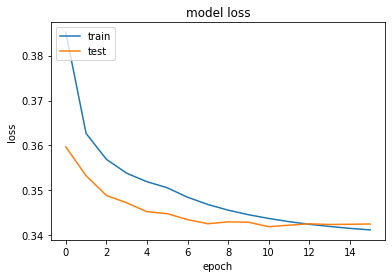

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

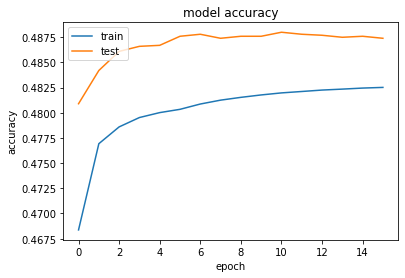

In [20]:
plt.plot(history2.history["accuracy"])
plt.plot(history2.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Save models

In [26]:
model2.save('DL.h5')